In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection
from nilearn import datasets as ds
from import_dataset import import_dataset, import_UKB_subs, dataset_to_data
from nilearn.input_data import NiftiLabelsMasker
from neuromaps import transforms
from neuromaps.stats import compare_images
from neuromaps import nulls
from nilearn.image import resample_img, math_img
from Brainplot.utilities import create_cereb_nii
import matplotlib
from map_colors import map_divergent
from sklearn.utils import resample
from pySankey.sankey import sankey
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors
from scipy.cluster.hierarchy import linkage, dendrogram


In [11]:
# Load data with regional volumes
df = pd.read_csv('data.csv')
# Print summary
df.iloc[:, 4:].head()

,site_num,CNV,genetic_stat2,age_spm,sex,volume,Front_Pole,Insula,Sup_Front_Gyr,Mid_Front_Gyr,...,I-IV_Cerebellum,V_Cerebellum,VI_Cerebellum,Crus_I_Cerebellum,Crus_II_Cerebellum,VIIb_Cerebellum,VIIIa_Cerebellum,VIIIb_Cerebellum,IX_Cerebellum,X_Cerebellum
0,5.0,Control,control,22.860274,1.0,656208.054260,-0.092960,0.046369,0.344461,-0.264657,...,-0.102233,0.032451,0.150079,-0.174795,-0.054574,-0.046199,0.047096,0.099211,-0.156032,0.153305
1,5.0,Control,control,21.230137,0.0,469667.024328,0.002016,0.080501,-0.008196,-0.038585,...,-0.144013,0.028179,0.107961,-0.124686,0.092272,-0.006210,-0.033934,-0.152433,-0.238413,0.166661
2,5.0,Control,control,39.063014,0.0,622233.118585,-0.083438,0.092485,0.355618,-0.004861,...,-0.016947,-0.005118,-0.031365,-0.065412,0.097700,-0.009841,-0.103504,-0.104361,-0.064086,0.090582
3,5.0,22q11.2,deletion,19.501370,1.0,560084.332875,-0.048563,-0.047620,0.044236,0.141042,...,-0.056222,0.047705,0.188013,0.114319,0.189179,-0.025723,-0.069550,-0.178888,-0.236144,-0.047871
4,5.0,Control,control,45.186301,1.0,543577.009900,-0.008999,-0.021376,0.519733,-0.167270,...,-0.197660,-0.065852,0.064221,-0.074985,-0.010784,0.065271,0.114610,0.077610,-0.175472,0.113341


In [62]:
# Dataframe with only CNVs
df_mutsubs = df[df.CNV != "Control"]
df_controls = df[df.CNV == "Control"]

# Arrays with brain volumes
X_full = np.array(df.iloc[:, 10:])
X_ctrl = X_full[df.CNV == "Control"]
X_mut = X_full[df.CNV != "Control"]
X_full_ss = scaler.fit_transform(X_full)
X_ctrl_ss = scaler.fit_transform(X_ctrl)
X_mut_ss = scaler.transform(X_mut)

Initialize plotting

In [13]:
matplotlib.rcParams["svg.fonttype"] = "none"
plt.rcParams.update({"font.family": "Helvetica Neue"})
cm = 1 / 2.54  # centimeters in inches

colors_cat = sns.color_palette("tab20", n_colors=len(category_names))
colors_cat.reverse()
colors_div = sns.color_palette("RdBu_r", n_colors=100)
color = ["#B64E6F", "#C0BFC0"]  # magenta grey

colors_two = []
for c in color:
    colors_two.append(matplotlib.colors.to_rgb(c))
colors_seq = sns.color_palette("Blues", n_colors=100)

tmp = ["#E8555F", "#0066B0"]  # Magenta blue
colors_two2 = []
for c in tmp:
    colors_two2.append(matplotlib.colors.to_rgb(c))

tmp = ["#028ECE", "#59C8EB", "#DF5F7E", "#EC9FB2",
       "#057186", "#6BA9B7", "#8E2043", "#BC7A8E"]
colors_eight = []
for c in tmp:
    colors_eight.append(matplotlib.colors.to_rgb(c))

Define functions

In [15]:
def cohen_d(x, y):
    # Calculate Cohen's d
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    res = (np.mean(x) - np.mean(y)) / np.sqrt(
        ((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2)
        / dof
    )
    return res


def boot_cohen(tmp1, tmp2, nboot):
    # Boostrap CI for Cohen's d
    cohen = cohen_d(tmp1, tmp2)
    boot_cohen = []
    for j in range(nboot):
        bs_replicates_1 = resample(
            tmp1, replace=True, n_samples=len(tmp1), random_state=j)
        bs_replicates_2 = resample(
            tmp2, replace=True, n_samples=len(tmp2), random_state=100 + j)
        boot_cohen.append(cohen_d(bs_replicates_1, bs_replicates_2))
    ci = np.array([cohen - np.percentile(boot_cohen, 2.5),
                   np.percentile(boot_cohen, 97.5) - cohen])
    return ci


def map_pearson(X, n):
    # Calculate Pearson correlation between pairs of AI
    r = np.zeros((n, n))
    p = np.zeros((n, n))
    for i in range(n - 1):
        for j in np.arange(i + 1, n):
            r[j, i], p[j, i] = pearsonr(X[i], X[j])
    p_sig, p_adj = fdrcorrection(p[np.tril_indices(p.shape[0], k=-1)])
    p = np.zeros((n, n))
    p[np.tril_indices(p.shape[0], k=-1)] = p_sig
    return r, p

def inverse_3maps(x):
    # Inverse transformation of LDA coefficients
    # Load maps
    harvard_oxford_cor = ds.fetch_atlas_harvard_oxford("cort-maxprob-thr0-1mm", symmetric_split=False)
    harvard_oxford_sub = ds.fetch_atlas_harvard_oxford("sub-maxprob-thr0-1mm", symmetric_split=False)
    # Create masks
    cortical_region = np.concatenate((np.ones(48, dtype=bool), np.zeros(17, dtype=bool)))
    subcortical_region = np.concatenate((np.zeros(48, dtype=bool), np.ones(7, dtype=bool), np.zeros(10, dtype=bool)))
    cereb_region = np.concatenate((np.zeros(55, dtype=bool), np.ones(10, dtype=bool)))
    # Create names
    cereb_names = rois_hem[cereb_region]
    cereb_names[3] = "CrusI_Cerebellum"
    cereb_names[4] = "CrusII_Cerebellum"
    left_cereb = ["Left_" + reg for reg in cereb_names]
    right_cereb = ["Right_" + reg for reg in cereb_names]
    cereb_names = np.concatenate((left_cereb, right_cereb))
    # Interse maskers
    masker_cor = NiftiLabelsMasker(labels_img=harvard_oxford_cor.maps,
                                   standardize=False, memory="nilearn_cache")
    masker_cor.fit()
    masker_sub = NiftiLabelsMasker(labels_img=harvard_oxford_sub.maps,
                                   standardize=False, memory="nilearn_cache")
    masker_sub.fit()
    # Reshape data
    data = x.reshape(-1, 1)
    # Create nifti images
    data_sub = np.concatenate((np.zeros(3), data[subcortical_region, 0]))
    data_sub = np.concatenate((data_sub, np.array([0]), data_sub))
    nifti_sub = masker_sub.inverse_transform(data_sub)
    data_cor = data[cortical_region, 0]
    nifti_cor = masker_cor.inverse_transform(data_cor)
    data_cer = np.tile(data[cereb_region, 0], 2)
    nifti_cereb = create_cereb_nii(pd.Series(data_cer, index=cereb_names), expt_type_abbr="Regular")
    # Upsample
    affine, shape = nifti_cor.affine, nifti_cor.shape
    nifti_cereb2 = resample_img(nifti_cereb, affine, shape[:3])
    # Combine
    result_img = math_img("img1 + img2 + img3", img1=nifti_cor, img2=nifti_sub, img3=nifti_cereb2)
    return result_img


def map_correlation(X, n):
    # Calculate Pearson correlation between pairs of brain maps
    r = np.zeros((n, n))
    p = np.zeros((n, n))
    for i in range(n - 1):
        print("Row:" + str(i))
        data1 = X[i]
        data1 = np.reshape(data1, (-1, 1))
        data1 = inverse_3maps(data1.T)
        data1 = transforms.mni152_to_fsaverage(data1, "10k")
        for j in np.arange(i + 1, n):
            data2 = X[j]
            data2 = np.reshape(data2, (-1, 1))
            data2 = inverse_3maps(data2.T)
            data2 = transforms.mni152_to_fsaverage(data2, "10k")
            # Null model
            rotated = nulls.alexander_bloch(data2, atlas="fsaverage", density="10k", n_perm=1000, seed=1)
            r[j, i], p[j, i] = compare_images(data1, data2, metric="pearsonr", nulls=rotated)
    p_sig, p_adj = fdrcorrection(p[np.tril_indices(p.shape[0], k=-1)])
    p = np.zeros((n, n))
    p[np.tril_indices(p.shape[0], k=-1)] = p_sig
    p2 = np.zeros((n, n))
    p2[np.tril_indices(p2.shape[0], k=-1)] = p_adj
    return r, p, p2


def err_bar(x):
    # Calculate 95% CI for mean
    low = np.percentile(x, 2.5)
    high = np.percentile(x, 97.5)
    return (low, high)

Classification targets

In [35]:
category_names = ["1q21.1del", "1q21.1dup", "15q11.2del", "15q11.2dup",
                  "16p11.2del", "16p11.2dup", "22q11.2del", "22q11.2dup"]

target_mut = df_mutsubs.CNV.map({"1q21.1": 0, "16p11.2": 1, "22q11.2": 2})
y_mut = df_mutsubs.genetic_stat2.map({"deletion": 0, "duplication": 1})

y = np.array(y_mut + (target_mut * 2))

Load derived asymmetry patterns

In [17]:
n_boot = 1000  # nb of bstraps
tmp = np.load("data/asymmetry_patterns.npz", allow_pickle=True)

all_models = tmp["all_models"]
all_models_avg = tmp["all_models_avg"]

/Users/jakubkopal/anaconda3/envs/CNV_asym/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LinearDiscriminantAnalysis from version 1.1.3 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Comparison of LDA coefficients with asymmetry indices

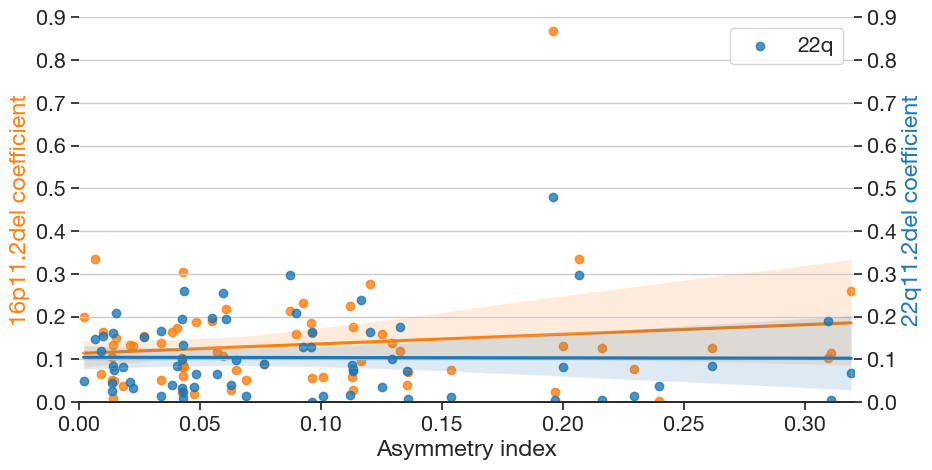

In [19]:
d = pd.DataFrame({"16p": np.abs(all_models_avg[4]),
                  "22q": np.abs(all_models_avg[6]),
                  "AI": np.abs(np.mean(X_ctrl, axis=0))})

sns.set_theme(style="ticks", palette="colorblind",
              font_scale=1.4, font="Helvetica Neue",
              rc={"axes.spines.right": False,
                  "axes.spines.top": False,
                  "axes.spines.left": False})
fig, ax1 = plt.subplots(1, figsize=(10, 5))
g1 = sns.regplot(x="AI", y="16p", data=d, color=colors_cat[5], label="16p")
plt.xlim(left=0, right=0.32)
plt.ylim(bottom=0, top=0.9)
ax2 = plt.twinx()
g2 = sns.regplot(x="AI", y="22q", data=d, color=colors_cat[7], label="22q")
plt.legend()
ax1.set_ylabel("16p11.2del coefficient", color=colors_cat[5])
ax2.set_ylabel("22q11.2del coefficient", color=colors_cat[7])
ax1.set_xlabel("Asymmetry index")
plt.xlim(left=0, right=0.32)
plt.ylim(bottom=0, top=0.9)
ax2.yaxis.grid()
plt.show()


Compare asymmetry patterns across CNVs

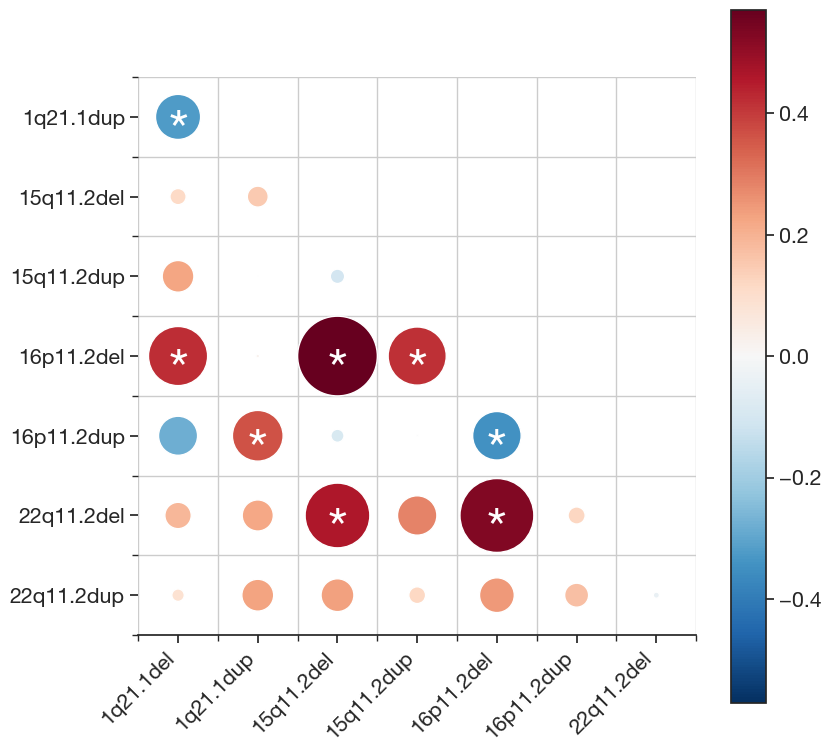

In [36]:

(r, p) = map_pearson(all_models_avg, len(category_names))
# (r, p, p_adj) = map_correlation(all_models_avg, len(category_names))
mask = np.triu(np.ones((r.shape[0] - 1, r.shape[0] - 1)), k=1)

# Hetmap
N = len(category_names) - 1
M = len(category_names) - 1
xx, yy = np.meshgrid(np.arange(M), np.arange(N))
r_short = r[1 : (len(category_names)), 0 : len(category_names) - 1]
p_short = p[1 : (len(category_names)), 0 : len(category_names) - 1]
R = r_short / r_short.max() / 2

sns.set_theme(style="ticks", palette="colorblind",
              font_scale=1.4, font="Helvetica Neue",
              rc={"axes.spines.right": False,
                  "axes.spines.top": False,
                  "axes.spines.left": False})
fig, ax = plt.subplots(1, figsize=(9, 9))
circles = [plt.Circle((j, i), radius=k) for k, j, i in zip(R.flat, xx.flat, yy.flat)]
col = PatchCollection(circles, array=r_short.flatten(), cmap="RdBu_r", norm=colors.CenteredNorm())
ax.add_collection(col)
# Annotate based on significance
for i in range(r_short.shape[0]):
    for j in range(i + 1):
        if p_short[i, j] == 1:
            ax.text(j, i + 0.22, "*", color="w",
                    size=40, ha="center", va="center")
ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=category_names[0: (len(category_names) - 1)],
       yticklabels=category_names[1: len(category_names)])
ax.set_xticks(np.arange(M + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(N + 1) - 0.5, minor=True)
plt.xticks(rotation=45, ha="right")  # Rotates X-Axis Ticks by 45-degrees
plt.yticks(rotation=0)
ax.invert_yaxis()
ax.grid(which="minor")
fig.colorbar(col)
ax.set_aspect("equal")
plt.show()


Hierarchical clustering of asymmetry patterns

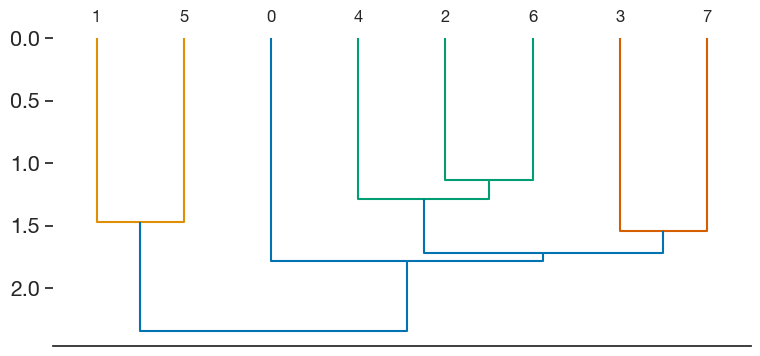

In [37]:
# Clustermap
sns.set_theme(style="ticks", palette="colorblind",
              font_scale=1.4, font="Helvetica Neue",
              rc={"axes.spines.right": False,
                  "axes.spines.top": False,
                  "axes.spines.left": False})
fig, ax = plt.subplots(1, figsize=(9, 4))
linkage_data = linkage(all_models_avg, method='ward', metric='euclidean')
dend = dendrogram(linkage_data, orientation='bottom')
order = np.array(dend['ivl'], dtype=int)
plt.show()

Bootstrap significance testing

In [38]:
mask_list = []
for i, cat in enumerate(category_names):
    tmp = all_models[i]
    coeff_boot = np.zeros((X_full.shape[1], n_boot))
    for j in range(n_boot):
        coeff_boot[:, j] = tmp[j].coef_
    boot_mean = np.mean(coeff_boot, axis=1)
    boot_ptile_low = np.percentile(coeff_boot, 2.5, axis=1)
    boot_ptile_high = np.percentile(coeff_boot, 97.5, axis=1)
    boot_ptile = (
        np.sign(boot_ptile_low) == np.sign(boot_ptile_high)
    ) * boot_mean
    mask = np.abs(boot_ptile) > 0
    mask_list.append(mask)

Barplot significant coefficients

/Users/jakubkopal/anaconda3/envs/CNV_asym/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jakubkopal/anaconda3/envs/CNV_asym/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jakubkopal/anaconda3/envs/CNV_asym/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jakubkopal/anaconda3/envs/CNV_asym/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jakubkopal/anaconda3/envs/CNV_asym/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/

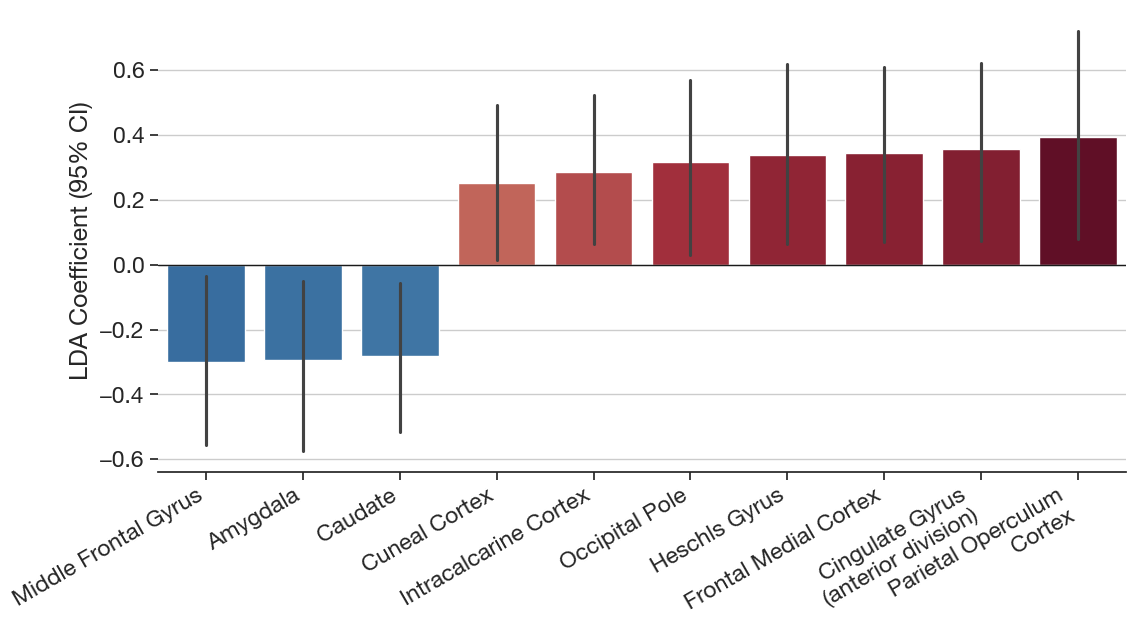

/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(
/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(


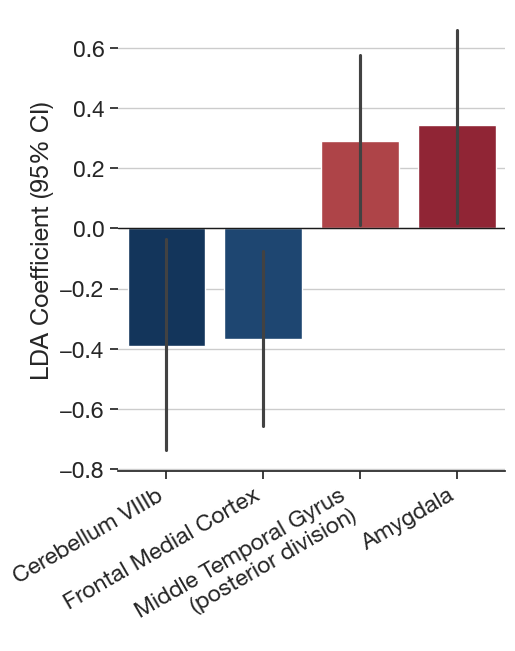

/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(
/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(


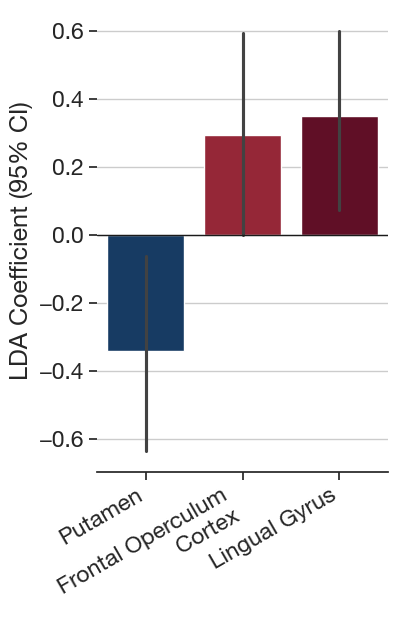

/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(
/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(


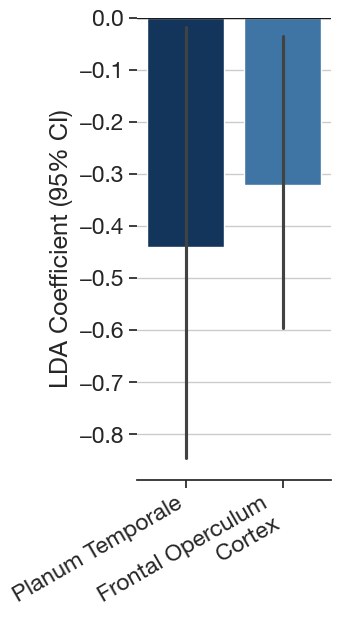

/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(
/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(


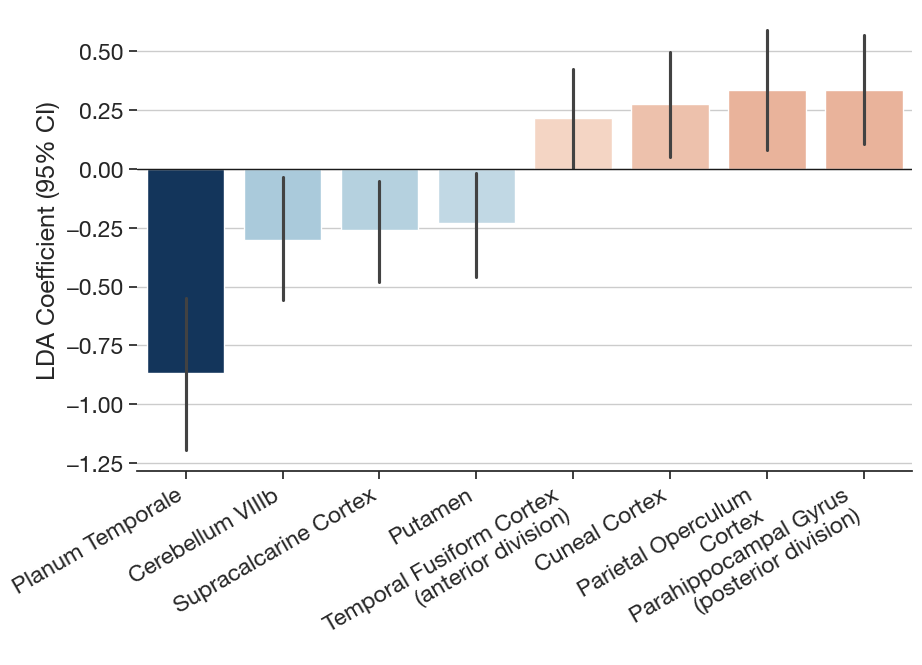

/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(
/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(


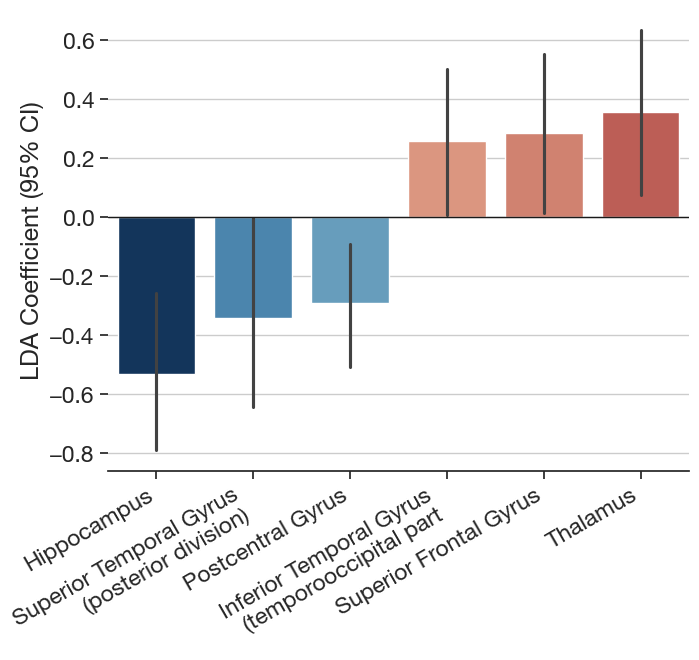

/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(
/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(


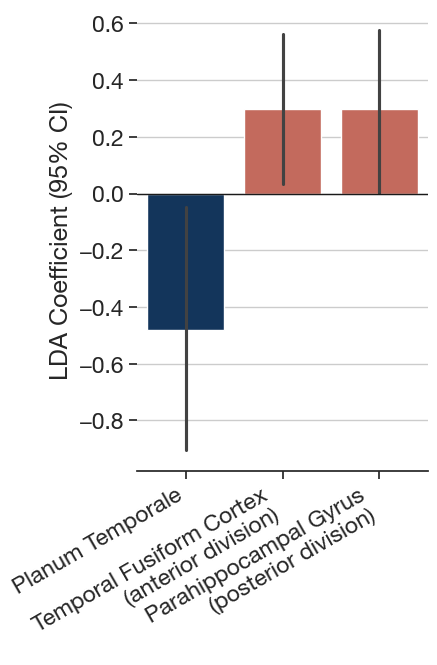

/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(
/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/4170969719.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(


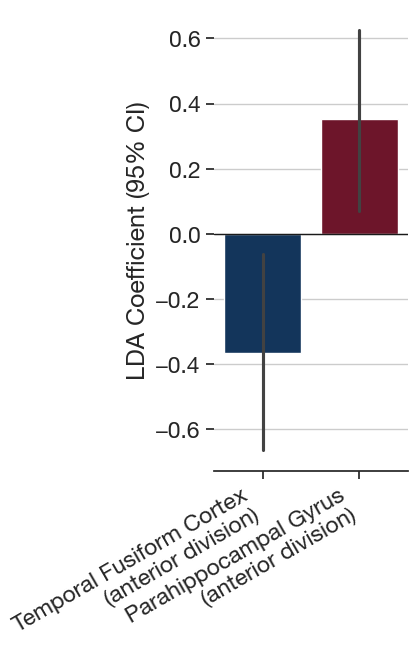

In [39]:
# Compute Cohen's d
X_coh = np.zeros((len(category_names), len(my_regions)))
for i, category in enumerate(category_names):
    for j in range(my_regions.shape[0]):
        X_coh[i, j] = cohen_d(X_mut_ss[y == i, j], X_ctrl_ss[:, j])

# Plot
for i, category in enumerate(category_names):
    category = category_names[i]
    d = pd.DataFrame({"Coefficient": all_models_avg[i, :][mask_list[i]],
                      "Region": my_regions[mask_list[i]]})
    
    # If there are any significant coefficients
    if len(d.index > 0):
        tmp = []
        for j in range(len(all_models[i, :])):
            tmp.append(all_models[i, j].scalings_[:, 0][mask_list[i]])
        tmp = np.array(tmp)
        df_tmp = pd.DataFrame(tmp, columns=my_regions[mask_list[i]])
        df_tmp = pd.melt(df_tmp)

        order = np.argsort(all_models_avg[i, :][mask_list[i]])
        clrs = map_divergent(d.Coefficient.values[order], "RdBu_r")

        # Plot
        sns.set_theme(style="ticks", palette="colorblind",
                      font_scale=1.4, font="Helvetica Neue",
                      rc={"axes.spines.right": False,
                          "axes.spines.top": False,
                          "axes.spines.left": False})
        fig = plt.figure(figsize=(1.25 * np.sum(mask_list[i]), 6))
        g = sns.barplot(x="variable", y="value", data=df_tmp, palette=clrs,
                        order=my_regions[mask_list[i]][order])
        g.set_title("")
        g.set_ylabel("LDA Coefficient (95% CI)")
        g.set_xlabel("")
        g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")
        g.yaxis.grid()
        plt.axhline(y=0, linestyle="-", linewidth=1, color="k")
        plt.show()
   

Cohen's d effect size for significant coefficients

/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/40363934.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(g.get_yticklabels(), rotation=0, size=16)
/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/40363934.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(g.get_yticklabels(), rotation=0)


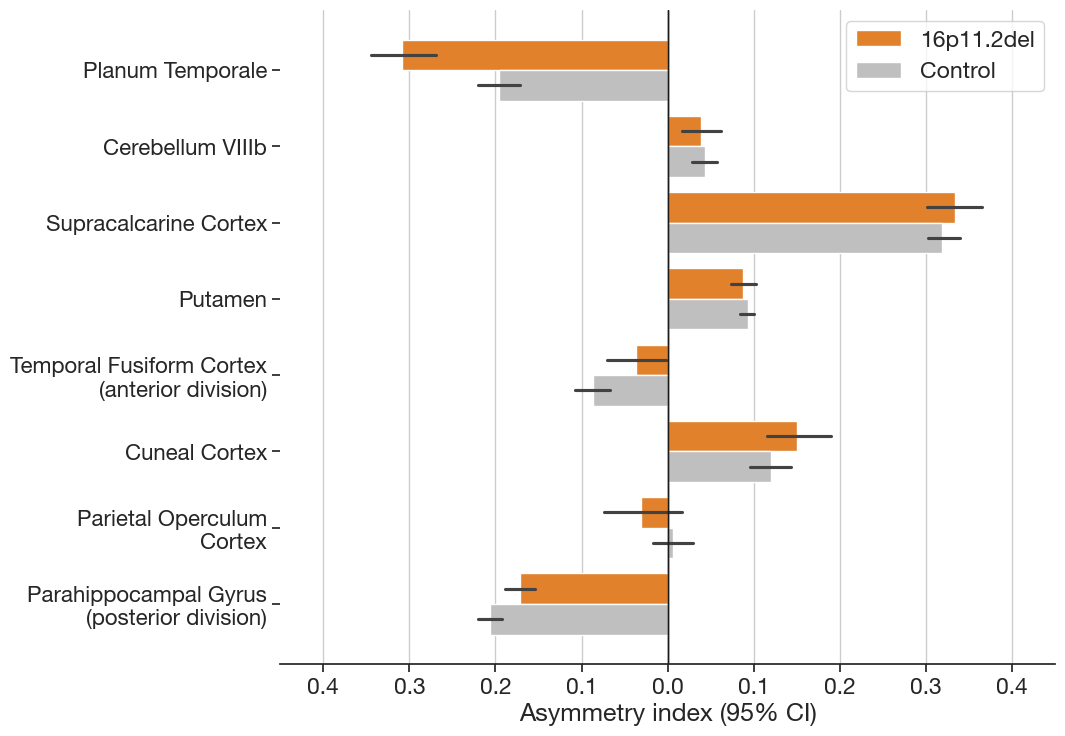

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/40363934.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45, size=16,


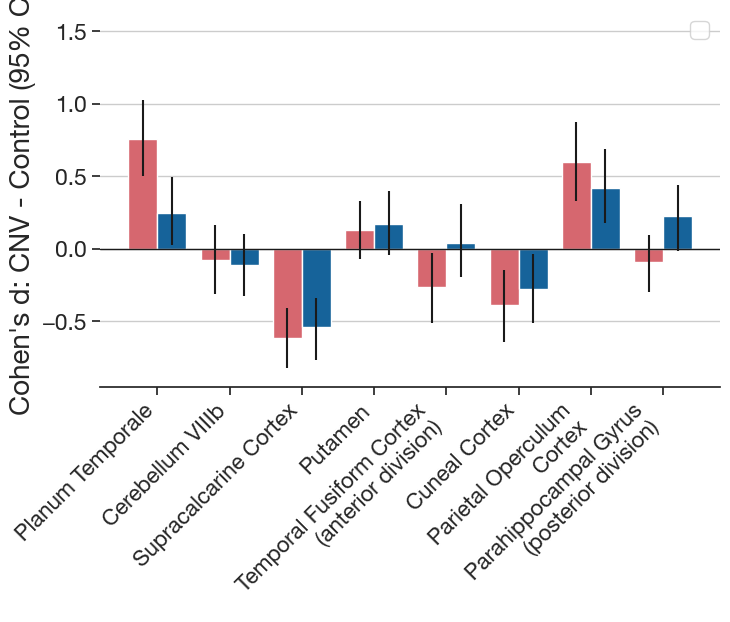

/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/40363934.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(g.get_yticklabels(), rotation=0, size=16)
/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/40363934.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(g.get_yticklabels(), rotation=0)


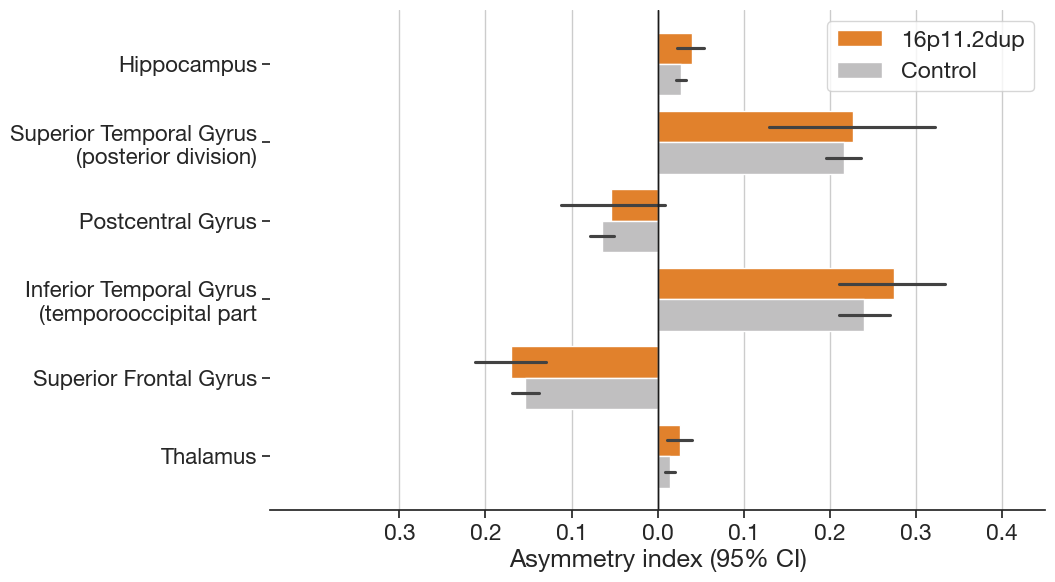

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_9936/40363934.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45, size=16,


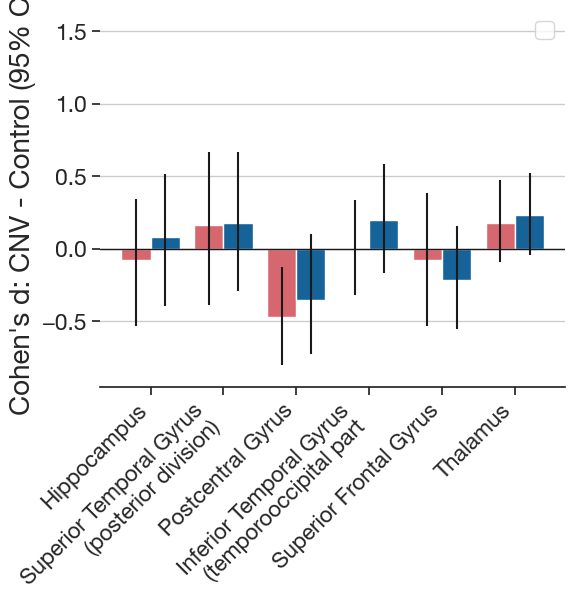

In [54]:
cats = [4, 5]
for ind, category in enumerate(category_names[4:6]):
    i = cats[ind]
    mask = mask_list[i]
    if np.sum(mask) > 1:
        X_cnv = X_mut[y == i, :]

        # From LDA coeff back to AI
        order = np.argsort(all_models_avg[i, :][mask])
        d = pd.DataFrame({"Volume": np.concatenate((-np.matrix.flatten(X_cnv[:, mask]),
                                                    -np.matrix.flatten(X_ctrl[:, mask]))),
                          "Region": np.concatenate((np.tile(my_regions[mask], X_cnv.shape[0]),
                                                    np.tile(my_regions[mask], X_ctrl.shape[0]))),
                          "Group": np.concatenate((np.repeat(category, X_cnv[:, mask].size),
                                                   np.repeat("Control", X_ctrl[:, mask].size)))})
        # Plot asymmetry index
        sns.set_theme(style="ticks", palette="colorblind", font_scale=1.5,
                      font="Helvetica Neue", rc={"axes.spines.right": False,
                                                 "axes.spines.top": False,
                                                 "axes.spines.left": False})
        fig, ax = plt.subplots(1, figsize=(10, 0.5 + np.sum(mask_list[i])))
        g = sns.barplot(x="Volume", y="Region", hue="Group",
                        palette=[colors_cat[int(np.floor(i / 2) * 2 + 1)], colors_two[1]],
                        errorbar=("ci", 95), data=d, order=my_regions[mask][order])
        g.set_title("", size=20)
        g.set_yticklabels(g.get_yticklabels(), rotation=0, size=16)
        g.set_xlabel("Asymmetry index (95% CI)", size=18)
        g.set_ylabel("")
        g.legend_.set_title("")
        g.set_yticklabels(g.get_yticklabels(), rotation=0)
        ticks_loc = g.get_xticks().tolist()
        g.set_xticks(g.get_xticks().tolist())
        g.set_xticklabels(np.round(np.abs(ticks_loc), 2))
        g.xaxis.grid()
        plt.axis("tight")
        xabs_max = abs(max(g.get_xlim(), key=abs))
        g.set_xlim(xmin=-xabs_max, xmax=xabs_max)
        plt.axvline(x=0, linestyle="-", linewidth=1, color="k")
        plt.axvline(x=0, linestyle="-", linewidth=1, color="k")
        plt.xlim((-0.45, 0.45))
        plt.show()

        # From lateralization back to left and right volume
        hems = ["Left", "Right"]
        d_mut_hem = []
        d_ctrl_hem = []
        d_mut_hem_ms = []
        d_ctrl_hem_ms = []
        for j, hem in enumerate(hems):
            X_full_hem = X_orig[:, 1 * j :: 2]
            X_hem_ctrl = X_full_hem[df.CNV == "Control", :]
            X_hem_ctrl = X_hem_ctrl[:, mask]
            X_hem_mut = X_full_hem[df.CNV != "Control", :]
            X_hem_mut = X_hem_mut[y == i, :]
            X_hem_mut = X_hem_mut[:, mask]

            d_mut_hem.append(X_hem_mut)
            d_ctrl_hem.append(X_hem_ctrl)

        # Cohen's d in each hemisphere
        X_mut_right = d_mut_hem[1]
        X_mut_left = d_mut_hem[0]
        X_ctrl_right = d_ctrl_hem[1]
        X_ctrl_left = d_ctrl_hem[0]
        coh_L = np.zeros(X_ctrl_left.shape[1])
        coh_R = np.zeros(X_ctrl_right.shape[1])
        coh_L_ci = np.zeros([X_ctrl_left.shape[1], 2])
        coh_R_ci = np.zeros([X_ctrl_right.shape[1], 2])
        for j in range(X_ctrl_left.shape[1]):
            coh_L[j] = cohen_d(X_mut_left[:, j], X_ctrl_left[:, j])
            coh_L_ci[j, :] = boot_cohen(X_mut_left[:, j], X_ctrl_left[:, j], 1000)
            coh_R[j] = cohen_d(X_mut_right[:, j], X_ctrl_right[:, j])
            coh_R_ci[j, :] = boot_cohen(X_mut_right[:, j], X_ctrl_right[:, j], 1000)

        d_left = pd.DataFrame({"cohen": coh_L}, index=my_regions[mask])
        d_left.reset_index(level=0, inplace=True)
        d_right = pd.DataFrame({"cohen": coh_R}, index=my_regions[mask])
        d_right.reset_index(level=0, inplace=True)

        d = pd.DataFrame({"coh": np.concatenate((coh_L, coh_R)),
                          "hem": np.concatenate((np.zeros(len(coh_L)), np.ones(len(coh_R)))),
                          "region": np.tile(my_regions[mask], 2)})
        # Both
        clrs = map_divergent(d.coh.values[np.tile(order, 2)], "RdBu_r")

        err = np.concatenate((coh_L_ci[order], coh_R_ci[order]))

        sns.set_theme(style="ticks", palette="colorblind", font_scale=1.5,
                      font="Helvetica Neue", rc={"axes.spines.right": False,
                                                 "axes.spines.top": False,
                                                 "axes.spines.left": False})
        fig, ax = plt.subplots(1, figsize=(np.sum(mask_list[i]), 4.9))
        g = sns.barplot(x="region", y="coh", hue="hem", legend=False,
                        data=d, palette=colors_two2, errorbar=None,
                        order=my_regions[mask][order])
        x_coords = [p.get_x() + 0.5 * p.get_width() for p in g.patches]
        y_coords = [p.get_height() for p in g.patches]
        g.errorbar(x=x_coords, y=y_coords, yerr=err.T, fmt="none", c="k")
        plt.legend()
        g.set_title("", fontsize=22)
        g.set_xlabel("", fontsize=20)
        g.set_ylabel("Cohen's d: CNV - Control (95% CI)", fontsize=20)
        g.set_xticklabels(g.get_xticklabels(), rotation=45, size=16,
                          ha="right", va="top")
        new_labels = ["Left", "Right"]
        for t, l in zip(g.legend_.texts, new_labels):
            t.set_text(l)
        g.legend_.set_title("")
        g.yaxis.grid()
        plt.axhline(y=0, linestyle="-", linewidth=1, color="k")
        plt.ylim((-0.95, 1.65))
        plt.show()

Sankey of significant coefficients


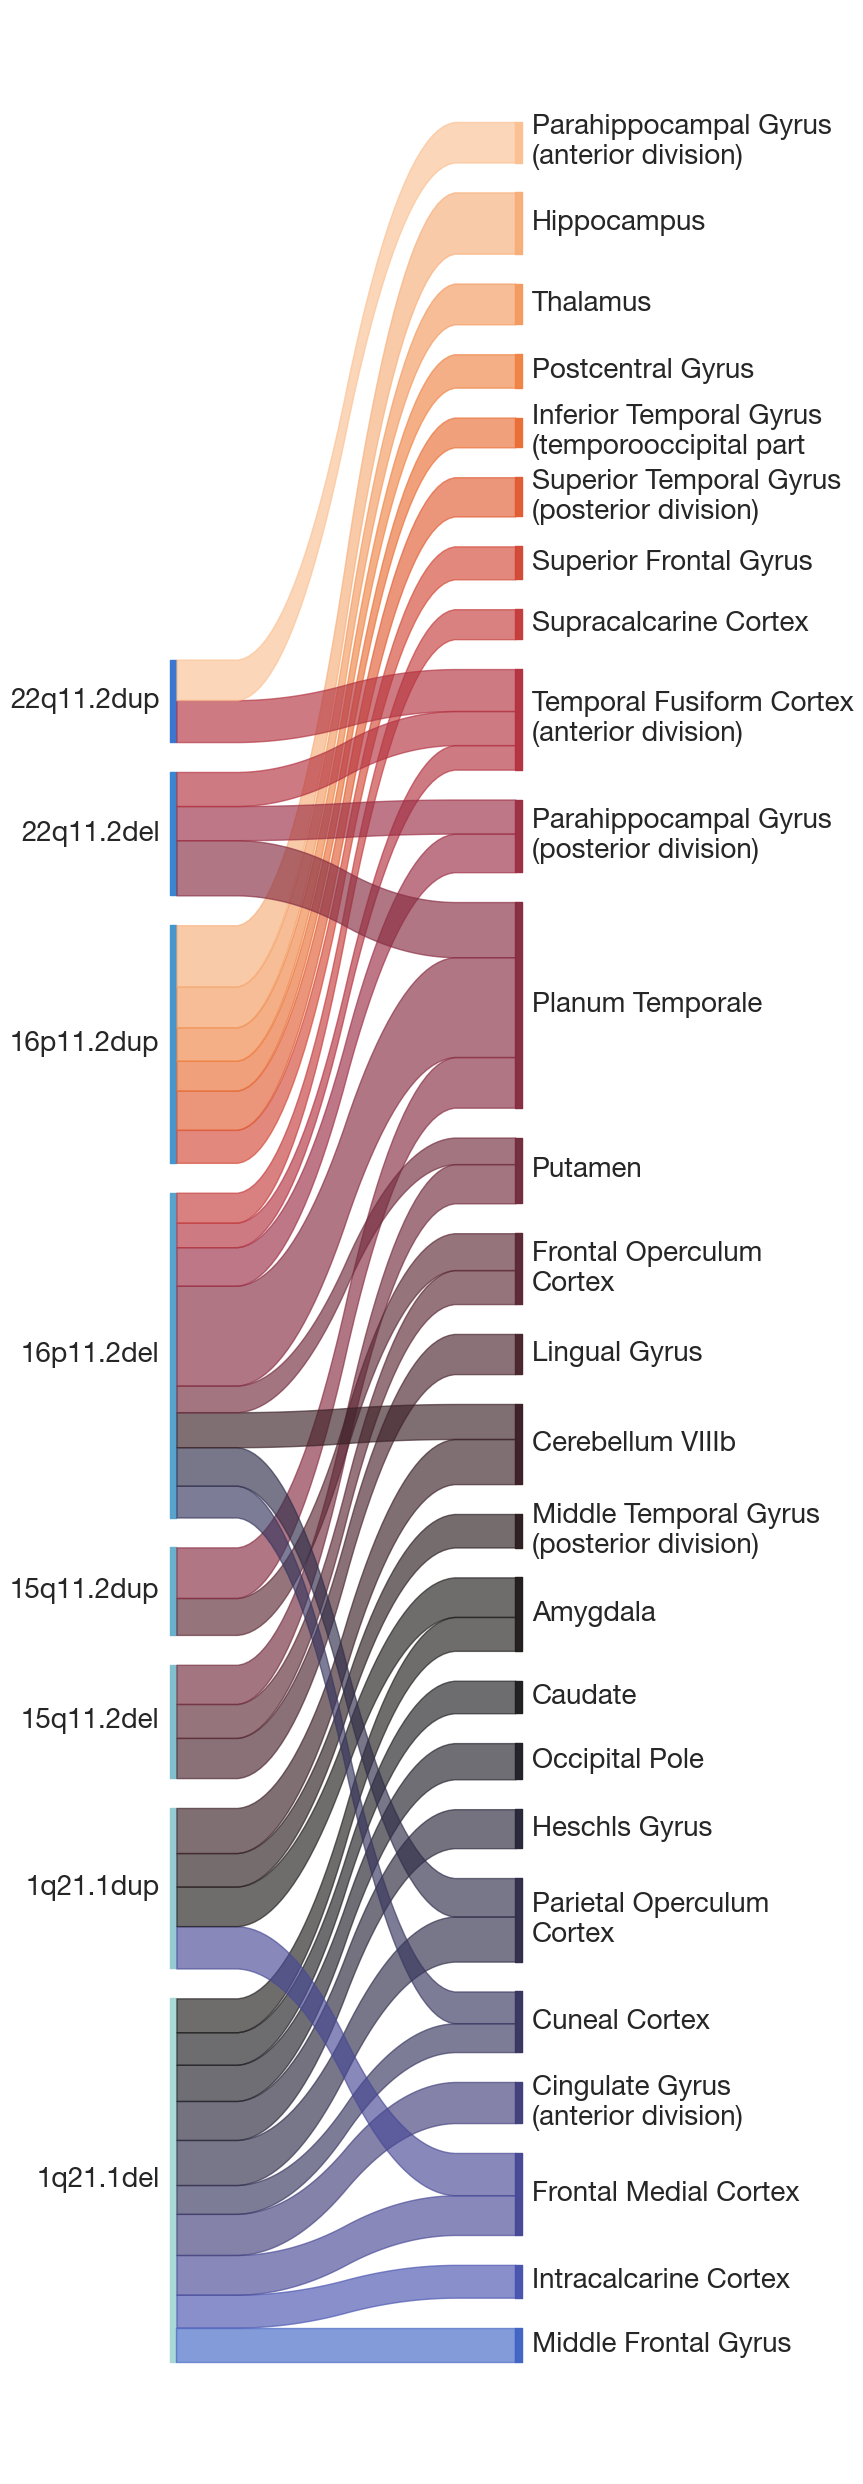

In [57]:
########################################################################
df = pd.DataFrame(columns=["mut", "reg"])
for i, cat in enumerate(category_names):
    tmp_df = pd.DataFrame(data=my_regions[mask_list[i]],
                          columns=[category_names[i]],
                          index=np.abs(all_models_avg[i][mask_list[i]]))
    tmp_df = pd.melt(tmp_df, var_name="mut", value_name="reg", ignore_index=False)
    df = pd.concat([df, tmp_df])
df = df.reset_index(drop=False)

plt.rcParams.update({"font.family": "Helvetica Neue"})
g = sankey(df["mut"], df["reg"], leftWeight=df["index"],
           aspect=100, fontsize=20, rightColor=True)
# Get current figure
fig = plt.gcf()
# Set size in inches
fig.set_size_inches(5, 32)
# Set the color of the background to white
fig.set_facecolor("w")
plt.show()